# Logo Detection

In this notebook, we develop a model to locate and lable company logos within static images.

#### Import dependencies

In [1]:
import numpy as np
import matplotlib.pylab as plt
import detectron2
import cv2
import os
import pathlib
import json
import random
from PIL import Image, ImageDraw2
import pandas as pd
import torchvision
from torchvision import transforms
import torch
import shutil
import glob

In [2]:
from detectron2.utils.logger import setup_logger
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.structures import BoxMode
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_train_loader, build_detection_test_loader

### Model Training

We need to train our model on some labled data sets. 

#### Load in the training data

In [3]:
def get_dicts(IMG_DIR):
    """Returns a list of dicts - one for each image
    Each dict contains labels and bounding boxes
    
    Each folder (train, val, test) contains a data.json file
    """

    path = os.path.join(IMG_DIR, 'data.json')
    dataset_dict = json.load(open(path))
    
    for item in dataset_dict:
        for ann in item['annotations']:
            ann['bbox_mode'] = BoxMode.XYXY_ABS    

    return dataset_dict

In [4]:
def get_metadata(dataset_name):
    metadata = MetadataCatalog.get(dataset_name)

    return metadata        

def sample_plot(dataset_dict, metadata, LOC):
    d = random.sample(dataset_dict, 1)[0]
    img = cv2.imread(os.path.join(LOC, d["file_name"]))
    visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:, :, ::-1])

In [5]:
def register(IMG_DIR, class_names, subfolders=['train', 'test']):
    """Register datasets for detectron2"""
    
    for d in subfolders:
        DatasetCatalog.register(f"{IMG_DIR}_{d}", lambda d=d: get_dicts(f'{IMG_DIR}/{d}'))
        MetadataCatalog.get(f"{IMG_DIR}_{d}").set(thing_classes=class_names)

In [6]:
logo_train = get_dicts('logo_detector/combined/train')

In [7]:
labels = list(pd.read_csv\
              ('logo_detector/combined/train/labels.csv')\
              ['class'].unique())

In [8]:
DatasetCatalog.clear() 
MetadataCatalog._NAME_TO_META = {}
register('logo_detector/combined/', labels, ['train', 'test'])

In [9]:
logo_train_metadata = get_metadata('logo_detector/combined_train')

['sas', 'rh', 'anaconda', 'cloudera']


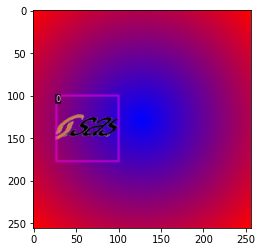

In [10]:
random.seed("summit2020")
sample_plot(logo_train, logo_train_metadata,'./')
print(labels)

#### Train the model

In [11]:
def prepare_for_training(N_iter,
                         output_dir,
                         train_dataset_name,
                         N_classes,
                         start_training=False):
    cfg = get_cfg()
    cfg.MODEL.DEVICE='cpu'
    cfg.merge_from_file(model_zoo.get_config_file\
                        ("COCO-Detection/faster_rcnn_R_50_C4_1x.yaml"))
    cfg.OUTPUT_DIR = output_dir
    cfg.DATASETS.TRAIN = (train_dataset_name,)
    cfg.DATASETS.TEST = ()
    cfg.DATALOADER.NUM_WORKERS = 2
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url\
                        ("COCO-Detection/faster_rcnn_R_50_C4_1x.yaml")
    cfg.SOLVER.IMS_PER_BATCH = 2
    cfg.SOLVER.BASE_LR = 0.00025  
    cfg.SOLVER.MAX_ITER = N_iter   
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = N_classes

    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
    trainer = DefaultTrainer(cfg)
    trainer.resume_or_load(resume=False)

    if start_training:
        trainer.train()

    return trainer, cfg 

In [12]:
N_classes = 4
trainer, cfg = prepare_for_training(20, 
                                    'logo_detector_output', 
                                    'logo_detector/combined/_train', 
                                    N_classes, 
                                    start_training=True)

[03/23 12:12:24 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv3): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
 

[03/23 12:12:24 d2.data.build]: Removed 0 images with no usable annotations. 512 images left.
[03/23 12:12:24 d2.data.build]: Distribution of instances among all 4 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|    sas     | 128          |     rh     | 128          |  anaconda  | 128          |
|  cloudera  | 128          |            |              |            |              |
|   total    | 512          |            |              |            |              |
[03/23 12:12:24 d2.data.common]: Serializing 512 elements to byte tensors and concatenating them all ...
[03/23 12:12:24 d2.data.common]: Serialized dataset takes 0.11 MiB
[03/23 12:12:24 d2.data.detection_utils]: TransformGens used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[03/23 12:12:24 d2.data.b

'roi_heads.box_predictor.cls_score.weight' has shape (81, 2048) in the checkpoint but (5, 2048) in the model! Skipped.
'roi_heads.box_predictor.cls_score.bias' has shape (81,) in the checkpoint but (5,) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.weight' has shape (320, 2048) in the checkpoint but (16, 2048) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.bias' has shape (320,) in the checkpoint but (16,) in the model! Skipped.


[03/23 12:12:25 d2.engine.train_loop]: Starting training from iteration 0
[03/23 12:23:03 d2.utils.events]:  eta: 0:00:32  iter: 19  total_loss: 2.305  loss_cls: 1.616  loss_box_reg: 0.512  loss_rpn_cls: 0.132  loss_rpn_loc: 0.019  time: 31.7415  data_time: 0.0547  lr: 0.000005  
[03/23 12:23:03 d2.engine.hooks]: Overall training speed: 17 iterations in 0:09:31 (33.6087 s / it)
[03/23 12:23:03 d2.engine.hooks]: Total training time: 0:09:31 (0:00:00 on hooks)


## Validating the model

Next, we see how well our model we just trained performs on logos which we know about.

todo: image showing the truth and the predicted for a few values. 

explain here how the accuracy is determined. 

first we see how many logos it correctly identified
 - confusion matrix
Then we see how much overlap there was, on average, between the bounding boxes in those training images, and the bounding boxes our model identified.

'sas': 82.5824281290984,
'rh': 79.00924387840708,
'anaconda': 86.84715918153037,
'cloudera': 70.13753486443517

## Running the model

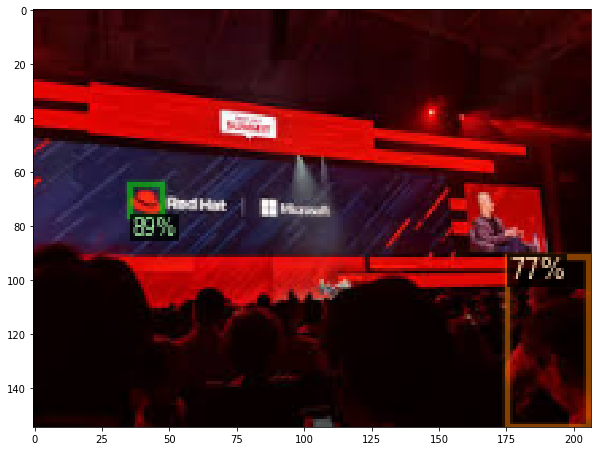

In [13]:
from IPython.display import Image
Image(filename='./Unknown.png')

## Publish the model - 

1. save binary to ceph s3
2. Submit a PR showing the model performance data